# Baby’s First Bayesian Model Using PyMC in Python

by Simon, link: <https://sthornewillve.medium.com/babys-first-bayesian-model-using-pymc-in-python-13af85cf4239>

I'm ashamed that I could not yet finish the book **Statistical Rethinking** like the author, let me try this at a first step. What we will do? -> fitting a normal distribution to data:

1. Construct a model with priors.
2. Perform a prior predictive check.
3. Fit the model and run diagnostics.
4. Perform a posterior predictive check.

## 1 Set up

We use `pymc` for Bayesian modeling, and `arviz` to plot and assess samples that we get from PyMC.

In [10]:
# Import packages
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

# Set seed
np.random.seed(42)

## 2 Simulate the data

The phenomenon to model: my cat knocks over my coffee mug, multiple times a day.

`scipy.poisson`: <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html>.

In [3]:
cat_knocks = stats.poisson(mu=4).rvs(14)
cat_knocks
# 4 times on avg per day, count over 14 days, rvs = random variates

array([3, 0, 5, 4, 6, 7, 1, 5, 2, 6, 6, 4, 3, 5])

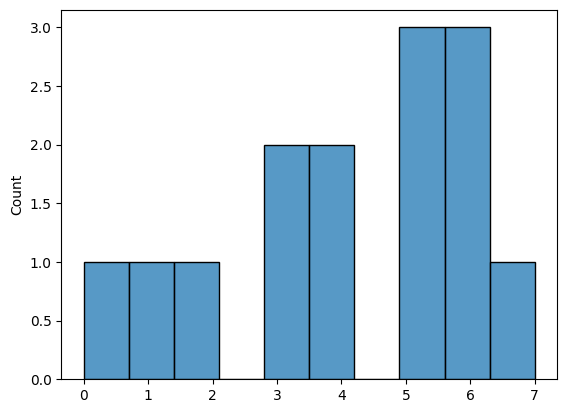

In [4]:
sns.histplot(cat_knocks, bins = 10)
plt.show()

## 3 Building the model

- `pymc.Normal()`: <https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Normal.html>.
- `pymc.HalfNormal()`: <https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html>.

In [5]:
with pm.Model() as cat_model:
    # we dont have specific expectation of how big is std deviation, so half-normal
    model_sigma = pm.HalfNormal("model_sigma", sigma=1)
    # expected average is 7 with std dev itself is 1
    model_mu = pm.Normal("model_mu", mu=7, sigma=1)
    
    likelihood = pm.Normal("likelihood", mu=model_mu, sigma=model_sigma, observed=cat_knocks)
    # pass data to the model using 'observe'

Dont look at the (current) data when building the prior, otherwise you are risking overfitting it.

## 4 Prior Predictive Checks

Let's see what kind of data it generates:

In [7]:
with cat_model:
    prior_pred = pm.sample_prior_predictive(samples=1000)

Sampling: [likelihood, model_mu, model_sigma]


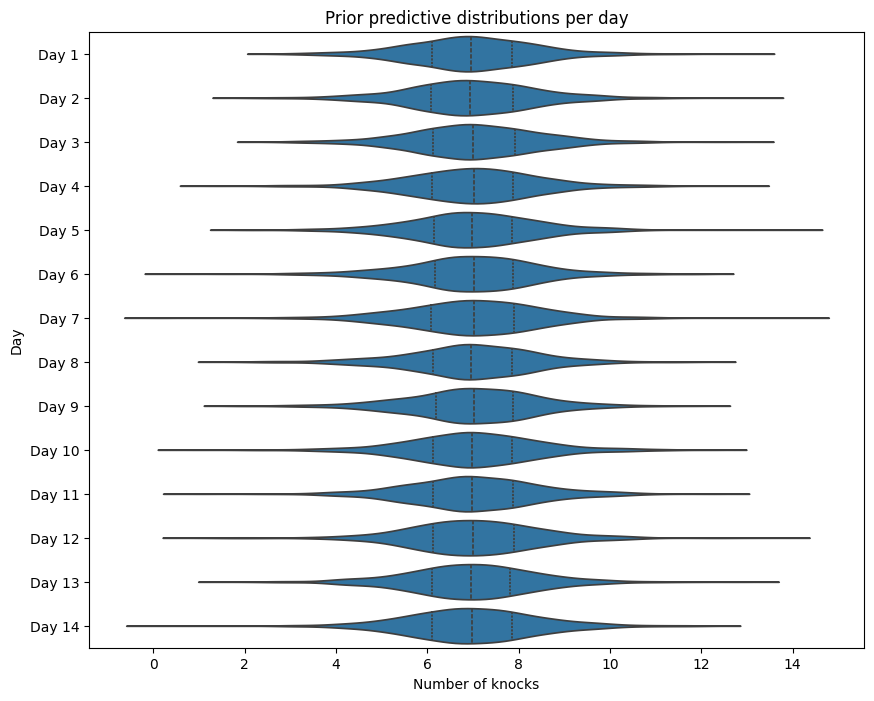

In [8]:
samples = prior_pred.prior_predictive.likelihood.squeeze()

df = pd.DataFrame(samples, columns=[f'Day {i+1}' for i in range(samples.shape[1])])
df_long = df.melt(var_name="Day", value_name="Number of knocks")
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

plt.figure(figsize=(10,8))
sns.violinplot(data=df_long, x="Number of knocks", y="Day", density_norm="width", inner="quartile")
plt.title("Prior predictive distributions per day")
plt.show()

## 5 Fitting and asessing the model

In [9]:
with cat_model:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [model_sigma, model_mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


> Fitting complex models is a skill, which is one of the big reasons why Bayesian statistics struggles with popularity.

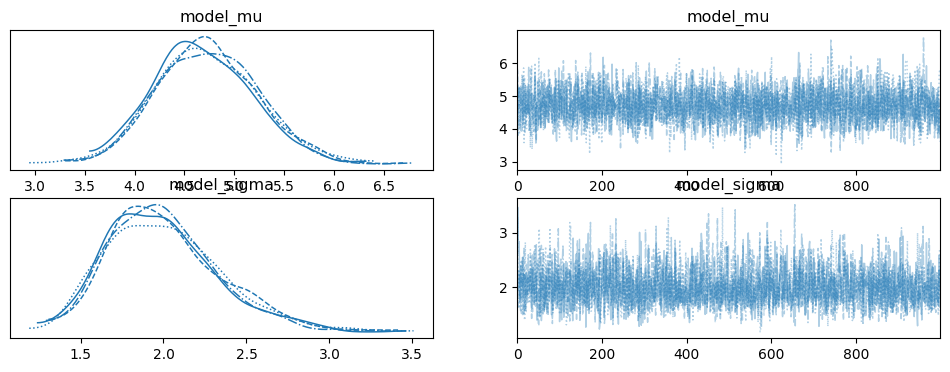

In [13]:
az.plot_trace(trace)
plt.show()
# KDE plots on the left, and trace plots on the right
# sampled in 4 independent chains
# very well, not a fuzzy caterpillar

In [14]:
az.summary(trace, round_to=2)[['mean', 'ess_bulk', 'r_hat']]

,mean,ess_bulk,r_hat
model_mu,4.72,2879.83,1.0
model_sigma,2.00,2876.00,1.0


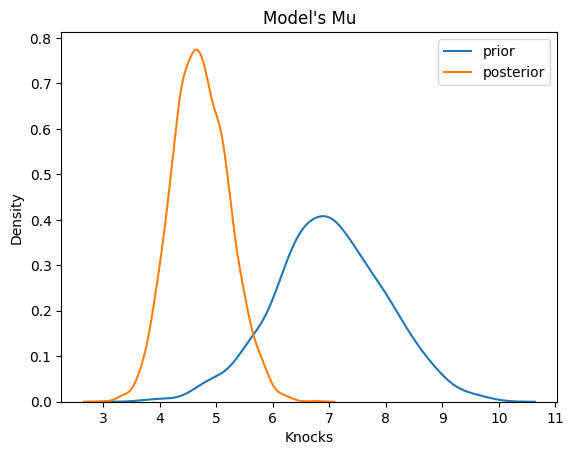

In [17]:
sns.kdeplot(prior_pred.prior.model_mu.values.squeeze(), label="prior")
sns.kdeplot(trace.posterior.model_mu.values.reshape(-1), label="posterior")
plt.legend()
plt.title("Model's Mu")
plt.xlabel("Knocks")
plt.show()

The likelihood of my cat knocks over my mug compared to my prior belief:

In [20]:
(trace.posterior.model_mu.values.reshape(-1)[:1000] < prior_pred.prior.model_mu.values.squeeze()).mean()

np.float64(0.985)

Meanwhile there was model variability than expected

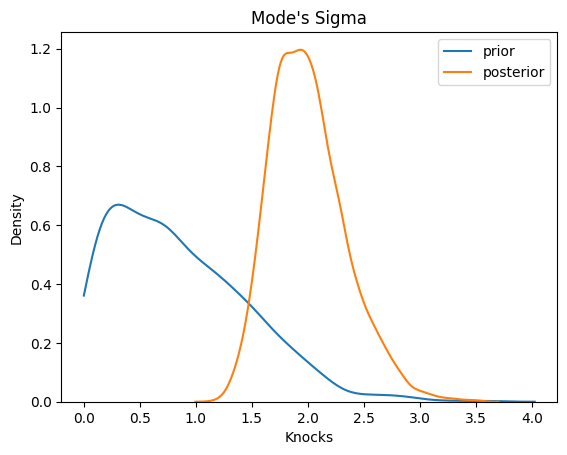

In [21]:
sns.kdeplot(prior_pred.prior.model_sigma.values.squeeze(), label="prior", clip=(0, 10))
sns.kdeplot(trace.posterior.model_sigma.values.reshape(-1), label="posterior", clip=(0, 10))
plt.legend()
plt.title("Mode's Sigma")
plt.xlabel("Knocks")
plt.show()

## 6 Posterior predictive check and statistics

Sampling: [likelihood]


Output()

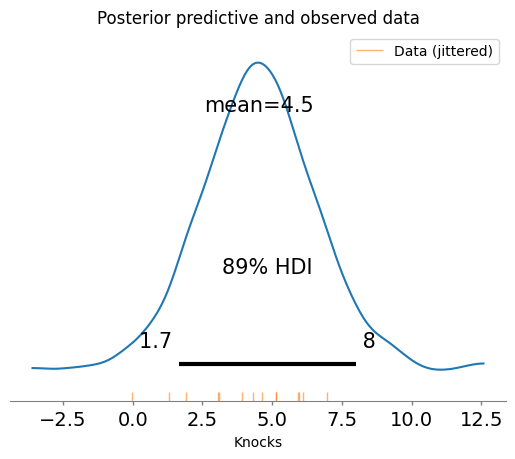

In [22]:
with cat_model:
    post_pred = pm.sample_posterior_predictive(trace, random_seed=42)
    
# add a small amount of random jitter to your observed data
jittered_knocks = cat_knocks + np.random.normal(0, 0.2, size=len(cat_knocks))

az.plot_posterior(post_pred.posterior_predictive.likelihood[0, :, 0], hdi_prob=0.89)
sns.rugplot(jittered_knocks, label='Data (jittered)', alpha=0.6, color=sns.color_palette()[1])

plt.legend()
plt.xlabel("Knocks")
plt.title("Posterior predictive and observed data")
plt.show()

## 7 Conclusion

> After fitting our data and assessing how well it sampled from the posterior distribution, we found that our initial impressions were too harsh and that our cat knocked over our mug close to 4 times a day instead of 7.

## Further reading

- The Hidden Power of Bayesian Methods in Business Decisions: <https://sthornewillve.medium.com/why-bayesian-methods-very-useful-for-business-decision-making-c533573de514>